In [7]:
library(INLA)
library(invgamma)
library("MASS")
library("fdrtool")

n = 100
x= (1:n) / n


[1] 100

[1] 100

[1] 100

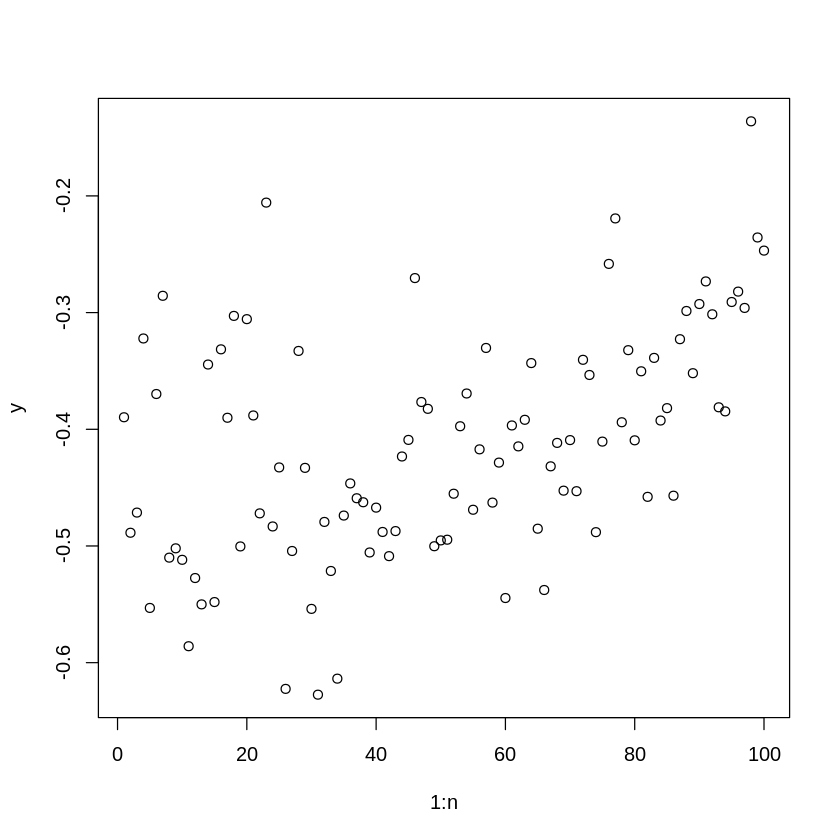

In [8]:
# =================================================
# gp definition

# kernel priors
length = 1
var = 1

# distance matrix
XtX <- tcrossprod(x)
XX <- matrix(1, n) %*% diag(XtX)
D <- XX - 2*XtX + t(XX) # distance matrix

# complete kernel
k = var * exp(-0.5 * (D/length ^ 2 ))
k = k + diag(2e-5, n, n)

f = mvrnorm(1, rep(0, n), k)

sigma = rhalfnorm(1, 25)
sigma_mat = rnorm(n, 0, sigma) 
y = f + sigma_mat
length(y)
length(f)
length(sigma_mat)

plot(1:n, y)
ground_truth = y

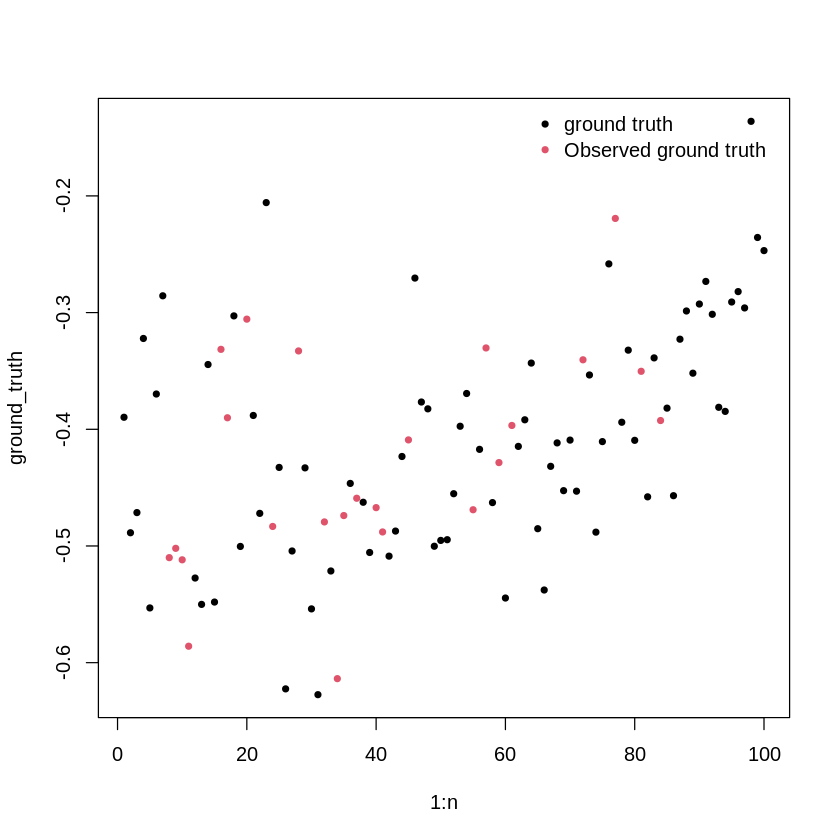

In [9]:
#ground_truth = c(-0.6965187788009644, -0.6679209470748901, -0.7103891372680664, -0.6851717829704285, -0.6841915249824524, -0.5668666362762451, -0.5722213387489319, -0.5780259966850281, -0.5724526047706604, -0.48403918743133545, -0.4543328881263733, -0.436381459236145, -0.3955748379230499, -0.3349480628967285, -0.2502446174621582, -0.29764896631240845, -0.2595856785774231, -0.16356737911701202, -0.06836479902267456, -0.10906502604484558, -0.03724215179681778, 0.06418919563293457, 0.06843328475952148, 0.14150741696357727, 0.12523609399795532, 0.17257541418075562, 0.2536618709564209, 0.3506408929824829, 0.3543667197227478, 0.3849707543849945, 0.4122837483882904, 0.5222899913787842, 0.5392687320709229, 0.4935515820980072, 0.5931767821311951, 0.6004530191421509, 0.6374411582946777, 0.6630330085754395, 0.6631835103034973, 0.6718357801437378, 0.71482914686203, 0.6407859921455383, 0.7441797852516174, 0.7126187682151794, 0.7239460349082947, 0.7214811444282532, 0.6694684028625488, 0.7093082070350647, 0.6740366816520691, 0.5644036531448364, 0.547078549861908, 0.5578815340995789, 0.5812382698059082, 0.4959672689437866, 0.5231911540031433, 0.5092390775680542, 0.4897089898586273, 0.35933029651641846, 0.3935067057609558, 0.3704443573951721, 0.23652081191539764, 0.2508527636528015, 0.1774042695760727, 0.14722715318202972, 0.10458831489086151, 0.10060330480337143, 0.04113604873418808, -0.022685861214995384, -0.036370061337947845, -0.12842771410942078, -0.15198564529418945, -0.17068874835968018, -0.21663402020931244, -0.2069537341594696, -0.2923087179660797, -0.37178802490234375, -0.2678752839565277, -0.38881829380989075, -0.4278460741043091, -0.5075673460960388, -0.45998191833496094, -0.5307313799858093, -0.5861528515815735, -0.5564097166061401, -0.6231715679168701, -0.5739148855209351, -0.6613097786903381, -0.7259194254875183, -0.6399742364883423, -0.6528728604316711, -0.6721140146255493, -0.7479739785194397, -0.6939185857772827, -0.7583205103874207, -0.767551839351654, -0.7348857522010803, -0.7188783884048462, -0.7831867933273315, -0.8078792691230774, -0.7973722815513611)

obs_idx = c(8, 9, 10, 11, 16, 17, 20, 24, 28, 32, 34, 35,37,40, 41, 45,55, 57,59, 61, 72, 77, 81, 84)
observations = rep(NA, n)

gt_plot_colours = rep(1, n)

for (i in 1:length(obs_idx)){
    observations[obs_idx[i]] = ground_truth[obs_idx[i]]
    gt_plot_colours[obs_idx[i]] = 2
}
na_points = which(is.na(observations))

plot(1:n, ground_truth, col=gt_plot_colours, pch=20)
legend("topright", legend = c("ground truth", "Observed ground truth"), col = 1:2, pch = 20, bty = "n")


In [10]:
# covariance matrix using exp-squared kernel, without lengthscale or variance
K = exp(-0.5 * dist(as.matrix(x), upper=TRUE, diag=TRUE, method="euclidean", p=2) ^2)

precision = Matrix::solve((K))

In [11]:
dim(precision)
dim(k)

[1] 100 100

[1] 100 100

In [12]:
plot_results <- function(results){
  inference_means_plus_true = rep(NA, n)
  colours = rep(NA, n)
  for (i in 1:length(obs_idx)){
    inference_means_plus_true[obs_idx[i]] = ground_truth[obs_idx[i]] 
    colours[obs_idx[i]] = 1
  }
  for (i in 1:length(na_points)){
    inference_means_plus_true[na_points[i]] = results$summary.fitted.values[i, c("mode")]
    colours[na_points[i]] = 2
  }


  plot(1:n, inference_means_plus_true, col=colours, pch=20)
  lines(results$summary.fitted.values[c("0.025quant")], col=3)
  lines(ground_truth, col=4)
  lines(results$summary.fitted.values[c("0.975quant")], col=3)
  legend("topright", legend = c("Observations", "Predicted", "95% CI", "Ground truth"), col = 1:4, pch = 20, bty = "n")


}

# INLA v1

In [13]:

kernel_prior <- list(prec = list(prior = "logtnormal", param = c(0, 10),
                                initial = 0, fixed = FALSE))


#  hyper=list(prec=list(prior= "expression:
#   tau0 = 0.001;
#   sigma = exp(-theta/2);
#   log_dens = log(2) - 0.5 * log(2 * pi) + 0.5 * log(tau0);
#   log_dens = log_dens - 0.5 * tau0 * sigma^2;
#   log_dens = log_dens - log(2) - theta / 2;
#   return(log_dens);  
# "))

sigma = rhalfnorm(1, 25)
noise = matrix(rnorm(n, 0, sigma), n, 1)

formula <- y ~ 1 + f(x1, Cmatrix = precision, hyper = kernel_prior,  model="generic") + noise #  f(x2, model="iid") 

results = inla(formula, data=list(y=observations, x1=1:n), family = "gaussian", control.predictor = list(compute = TRUE), verbose = TRUE,
                    # safe=TRUE,
                    inla.mode = "experimental",
                    )

plot_results(results)


Error in inla.inlaprogram.has.crashed() : 
  The inla-program exited with an error. Unless you interupted it yourself, please rerun with verbose=TRUE and check the output carefully.
  If this does not help, please contact the developers at <help@r-inla.org>.

 *** inla.core.safe:  inla.program has crashed: rerun to get better initial values. try=1/2 
Error in inla.inlaprogram.has.crashed() : 
  The inla-program exited with an error. Unless you interupted it yourself, please rerun with verbose=TRUE and check the output carefully.
  If this does not help, please contact the developers at <help@r-inla.org>.

 *** inla.core.safe:  inla.program has crashed: rerun to get better initial values. try=2/2 
Error in inla.inlaprogram.has.crashed() : 
  The inla-program exited with an error. Unless you interupted it yourself, please rerun with verbose=TRUE and check the output carefully.
  If this does not help, please contact the developers at <help@r-inla.org>.


ERROR: Error in inla.core.safe(formula = formula, family = family, contrasts = contrasts, : *** Fail to get good enough initial values. Maybe it is due to something else.


# INLA v2

Warning message in inla.model.properties.generic(inla.trim.family(model), mm[names(mm) == :
“Model 'z' in section 'latent' is marked as 'experimental'; changes may appear at any time.
  Use this model with extra care!!! Further warnings are disabled.”


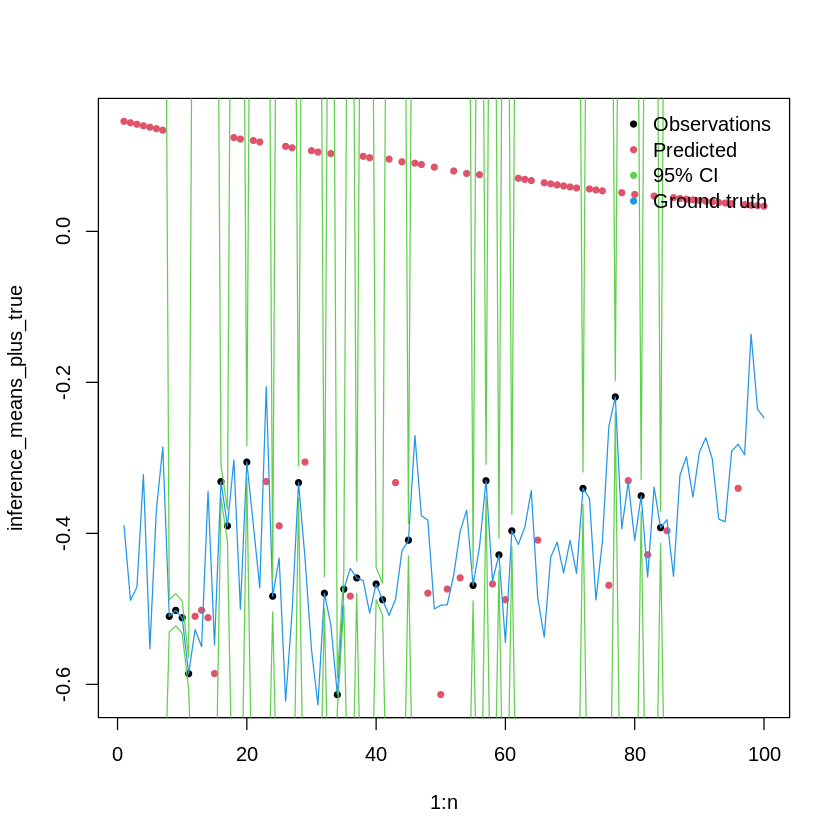

In [14]:
# does not have lengthscale yet!
kernel_prior <- list(prec = list(prior = "logtnormal", param = c(0, 10),
                                initial = 0, fixed = FALSE))


formula <- y ~ 0 + f(x1, Z=diag(1, n, n), Cmatrix = precision, hyper = kernel_prior,  model="z") + f(x2, model="iid") 

#  hyper=list(prec=list(prior= "expression:
#   tau0 = 0.001;
#   sigma = exp(-theta/2);
#   log_dens = log(2) - 0.5 * log(2 * pi) + 0.5 * log(tau0);
#   log_dens = log_dens - 0.5 * tau0 * sigma^2;
#   log_dens = log_dens - log(2) - theta / 2;
#   return(log_dens);  
# "))) 

results = inla(formula, data=list(y=observations, x1=1:n, x2=1:n), family = "gaussian", control.predictor = list(compute = TRUE), verbose = TRUE,)
                    # safe=FALSE,
                    # inla.mode = "experimental")


plot_results(results)

# INLA v3

In [24]:

dat <- list(id = 1:n,
            y = observations
            )

# sigma ~ N(0. 2.5^2); initial in terms of log(tau) so 0 corresponds to tau = 1
tau_prior <- list(prec = list(prior = "logtnormal", param = c(0, 1/2.5^2),
                            initial = 0, fixed = FALSE))

beta_prior <- list(mean.intercept = -2, prec.intercept = 1)

# See inla.doc("generic0")
formula <- y ~ 1 + f(id, model = "generic0", Cmatrix = precision, hyper = tau_prior)

fit <- INLA::inla(formula,
                family = "gaussian", # was "xbinomial"
                control.family = list(control.link = list(model = "logit")),
                control.fixed = beta_prior,
                data = dat,
                #Ntrials = m,
                control.predictor = list(compute = TRUE), #  link = 1
                control.compute = list(
                    dic = TRUE, waic = TRUE, cpo = TRUE, config = TRUE, 
                    return.marginals.predictor = TRUE
                ),
                verbose = TRUE,
                debug=TRUE,
                #num.threads = cores,
                inla.mode = "experimental")

[1] "head(scale)"
NULL
[1] "head(weights)"
NULL
[1] "head(Ntrials)"
NULL
[1] "head(offset)"
NULL
[1] "head(E)"
NULL
[1] "head(strata)"
NULL
[1] "head(lp.scale)"
NULL
[1] "head(link.covariates)"
NULL
[1] "MPredictor 0"
[1] "NPredictor 100"
[1] "NData 100"
[1] "y...fake has length 100"
n.family 1 
[1] "Entries with same length:" "id"                       
[3] "y...fake"                 
[1] "prepare problem section"
Prepare inla file.....inla.create.data.file: n.data =  100 
[1] "\nOpen file to write /tmp/RtmpO4rf9d/file2dfbac730fc7e2/data.files/file2dfbac468fe50a"
[1]  0 72 24  3  0  1  0  1
[1] "\nOpen file to write /tmp/RtmpO4rf9d/file2dfbac730fc7e2/data.files/file2dfbacfa5252d"
[1] 0 1 1 1 0 1 0 1
[1] "prepare data section"
[1] "prepare predictor section"
[1] "\nOpen file to write /tmp/RtmpO4rf9d/file2dfbac730fc7e2/data.files/file2dfbac5e864211"
[1]   0 200 100   2   0   1   0   1
write label[ (Intercept) ]
[1] "\nOpen file to write /tmp/RtmpO4rf9d/file2dfbac730fc7e2/data.files/file

ERROR: Error in inla.core.safe(formula = formula, family = family, contrasts = contrasts, : *** Fail to get good enough initial values. Maybe it is due to something else.


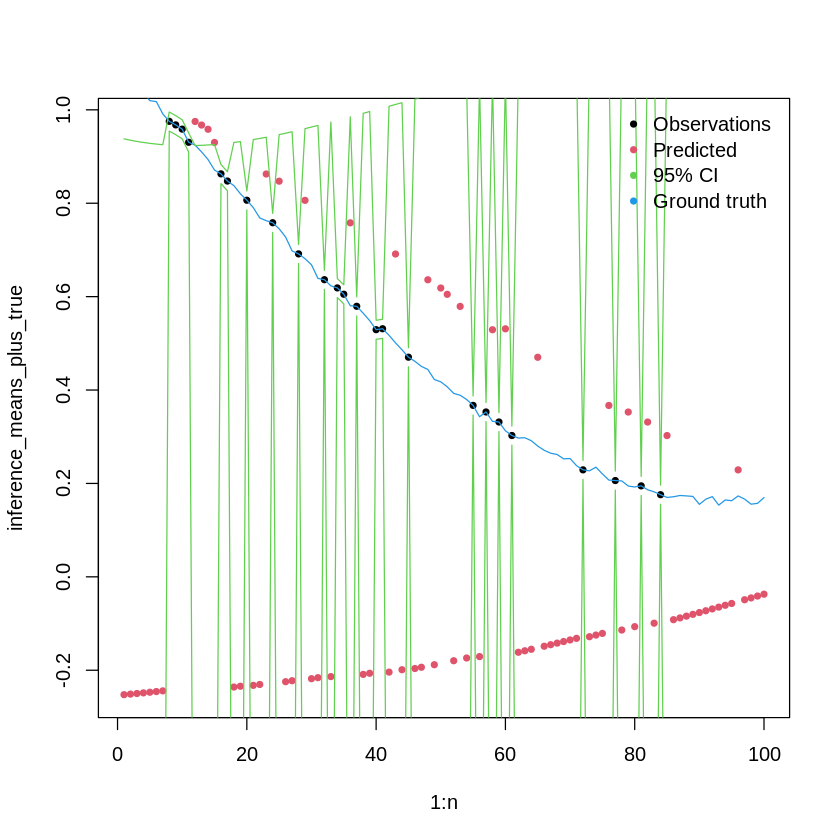

In [ ]:
results$summary.fitted.values